# 02. Neural Network Classification with Pytorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options)

## 1. Make classification data and get it ready

In [1]:
import sklearn  # type: ignore
from sklearn.datasets import make_circles # type: ignore

sklearn.show_versions()


System:
    python: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
executable: c:\Users\bolth\anaconda3\python.exe
   machine: Windows-11-10.0.22635-SP0

Python dependencies:
      sklearn: 1.5.1
          pip: 24.0
   setuptools: 69.5.1
        numpy: 1.26.4
        scipy: 1.14.0
       Cython: None
       pandas: 2.2.2
   matplotlib: 3.8.4
       joblib: 1.4.2
threadpoolctl: 3.5.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: mkl
    num_threads: 12
         prefix: mkl_rt
       filepath: C:\Users\bolth\anaconda3\Library\bin\mkl_rt.2.dll
        version: 2023.1-Product
threading_layer: intel

       user_api: openmp
   internal_api: openmp
    num_threads: 16
         prefix: vcomp
       filepath: C:\Users\bolth\anaconda3\vcomp140.dll
        version: None


In [2]:
# make 1000 samples
n_samples = 1000

# create circles (X for matrix and y for labels)
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X: \n{X[:5]}")
print(f"First 5 samples of y: \n{y[:5]}")
# the elements of y is binary whereas elements of X is more diverge
# it looks that y is label for X (binary classification)

First 5 samples of X: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: 
[1 1 1 1 0]


In [5]:
# make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [6]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

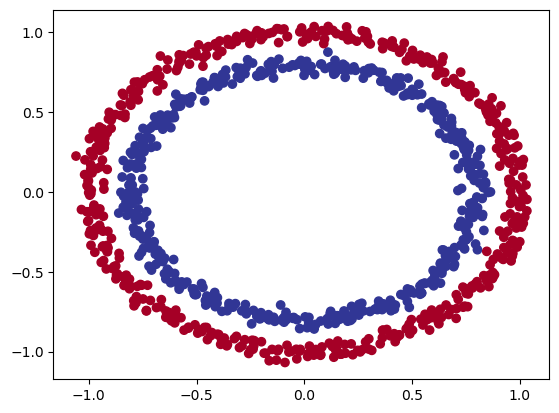

In [7]:
import matplotlib.pyplot as plt 
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

**Note:** The data we're working with is often referred as a toy dataset, a dataset that is small enought to practice the fundamentals.

learn more - https://scikit-learn.org/stable/datasets/toy_dataset.html

### 1.1 Check input and output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
# view the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data intotensor and create train and test splits

In [10]:
import torch 
torch.__version__

'2.4.0'

In [11]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [12]:
# turn data into tensors 
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
# split data into training and test sets
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split # type: ignore

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# this is the default order from scikit for random data splitting

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

The objective is to build a model that can classify the blue and red dots. 

To do so, these are the following steps:
1. Setup device agnostic code so the code will run on an accelarator (GPU)
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [15]:
from torch import nn 

# make device agnostic code 
device = "cuda" if torch.cuda.is_available else "cpu"
print(f"Device: {device}")

Device: cuda


In [16]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

There are some few steps to buld the model:

1. Subclasses `nn.Module` 
2. Create two `nn.Linear()` layers that are capable of handling the shapes of the data
3. Define a `forward()` method that outlines the forward pass (forward propagation) of the model
4. Instantiate an instance of the model class and send it to the target `device`

In [17]:
# input features
X_train.shape, X_train.ndim

(torch.Size([800, 2]), 2)

In [18]:
# output feature
y_train.shape, y_train[0], y_train.ndim

(torch.Size([800]), tensor(1.), 1)

In [19]:
# 1. construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. create 2 nn.Linear layers for handling the shapes for the data (X_train has shape of two)
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (shape of X) and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from prev layer (out_features of layer_1) and output a single feature (same shape as y)

        # self.two_linear_layers = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )

    # 3 define a forward method that outlines (forward propagation)
    def forward(self, x: torch.Tensor):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2
        ## return self.two_linear_layers(x)

# 4. instantiate an instance of the model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

neural network playground - [tensorflow-playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.39974&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

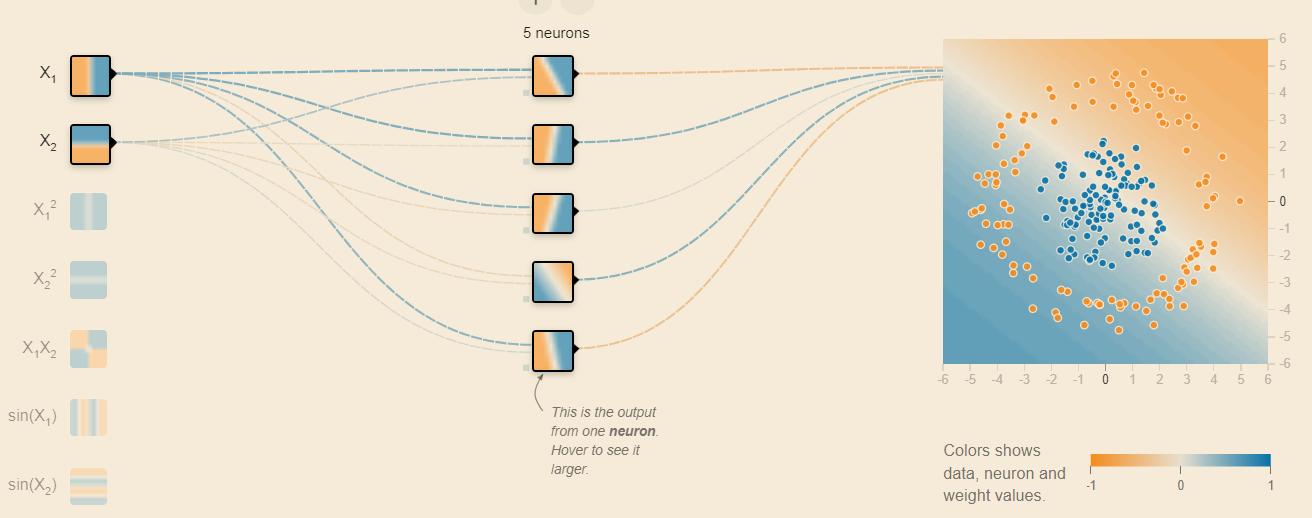


In [20]:
# replicating the model above using nn.Sequential()
model_0_with_sequential = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)
model_0_with_sequential

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5809,  0.4804],
                      [ 0.4250, -0.5628],
                      [-0.4536,  0.2021],
                      [-0.5221, -0.1699],
                      [-0.2030,  0.1047]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3610, -0.7068,  0.4155,  0.2720,  0.2810], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.0326,  0.3831,  0.3715, -0.3840, -0.1547]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.1854], device='cuda:0'))])

### 2.1 Setup loss function and optimizer 
which loss function or optimizer should be used? 
well this is problem specific, you'll figure it out overtime you build machine learning models

For example:
- for regression problem you might want MAE or MSE (mean absolute error or mean squared error). 
- for classification problem, you might want binary cross entropy or categorical cross entropy.

And for optimizers, two of the most common and useful are SGD and Adam, however pytorch has many built-in options.

* For the loss function we're going to use `torch.nn.BECWithLogitsLoss()`, for more on what binary cross entropy is, check out this article - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

In [22]:
# setup loss function 
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001)

In [23]:
torch.eq(torch.tensor(data=[[1, 2], [3, 4]]), torch.tensor([[1, 1], [3,1]]))

tensor([[ True, False],
        [ True, False]])

In [24]:
# calculate accurary - out of 100 examples, what percentage does our model get right?
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # eq tells how many is the value of y_pred that equals to y_true
    acc = (correct/len(y_pred)) * 100 
    return acc

## 3. Training the model

1. feed forward 
2. calculate loss
3. optimize zero grad (for efficient computation)
4. loss backward (backprop)
5. optimize step

### 3.1 going from raw logits -> prediction probabilities -> prediction labels

The outputs of our model are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. Sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the ``argmax()``

In [25]:
# view the first 5 outputs (raw logits) of the forward pass on the test data
with torch.inference_mode():   
    y_logits = model_0(X_test.to(device))[:5] # without being passed to any activation function
y_logits

tensor([[-0.5889],
        [-0.5377],
        [-0.5499],
        [-0.6007],
        [-0.2748]], device='cuda:0')

In [26]:
# use the sigmoid activation function on the model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3569],
        [0.3687],
        [0.3659],
        [0.3542],
        [0.4317]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:
- `y_pred_probs` >= 0.5, `y=1` (class 1)
- `y_pred_probs` < 0.5, `y=0` (class 0)

In [27]:
# find the predicted labels
torch.round(y_pred_probs), y_test[:5] # now it's apple to apple with the y_test

(tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.]))

In [28]:
y_preds = torch.round(y_pred_probs)

# full expression
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for equality 
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

### 3.2 Building training and testing loop

In [29]:
# set the epochs
epochs = 1000

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train.to(device)).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # loss = loss_fn(torch.sigmoid(y_logits), y_train) nn.BCELoss expects prediction probabilities as input
    loss = loss_fn(y_logits, y_train.to(device))
    acc = accuracy(y_true=y_train.to(device), y_pred=y_preds)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test.to(device)).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test.to(device))
        test_acc = accuracy(y_true=y_test.to(device), y_pred=test_preds)
    if epoch % 100 == 0:
        print(f"epoch: {epoch} | Loss: {loss:.5f}, accuracy: {acc:.2f} | testing loss: {test_loss:.5f}, test accuracy: {test_acc:.2f} ")

epoch: 0 | Loss: 0.71958, accuracy: 50.00 | testing loss: 0.71987, test accuracy: 50.00 
epoch: 100 | Loss: 0.71651, accuracy: 50.00 | testing loss: 0.71672, test accuracy: 50.00 
epoch: 200 | Loss: 0.71380, accuracy: 50.00 | testing loss: 0.71394, test accuracy: 50.00 
epoch: 300 | Loss: 0.71140, accuracy: 50.00 | testing loss: 0.71148, test accuracy: 50.00 
epoch: 400 | Loss: 0.70929, accuracy: 50.00 | testing loss: 0.70931, test accuracy: 50.00 
epoch: 500 | Loss: 0.70742, accuracy: 50.00 | testing loss: 0.70739, test accuracy: 50.00 
epoch: 600 | Loss: 0.70578, accuracy: 50.00 | testing loss: 0.70570, test accuracy: 50.00 
epoch: 700 | Loss: 0.70432, accuracy: 50.00 | testing loss: 0.70421, test accuracy: 50.00 
epoch: 800 | Loss: 0.70304, accuracy: 50.00 | testing loss: 0.70289, test accuracy: 50.00 
epoch: 900 | Loss: 0.70190, accuracy: 50.00 | testing loss: 0.70172, test accuracy: 50.00 


## 4. Make predictions and evaluate the model

From the metrics it looks like the model isn't learning anything.
So, to inspect it let's make some predictions and make them visual

In [30]:
import requests
from pathlib import Path 

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists!")
else:
    print("downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists!


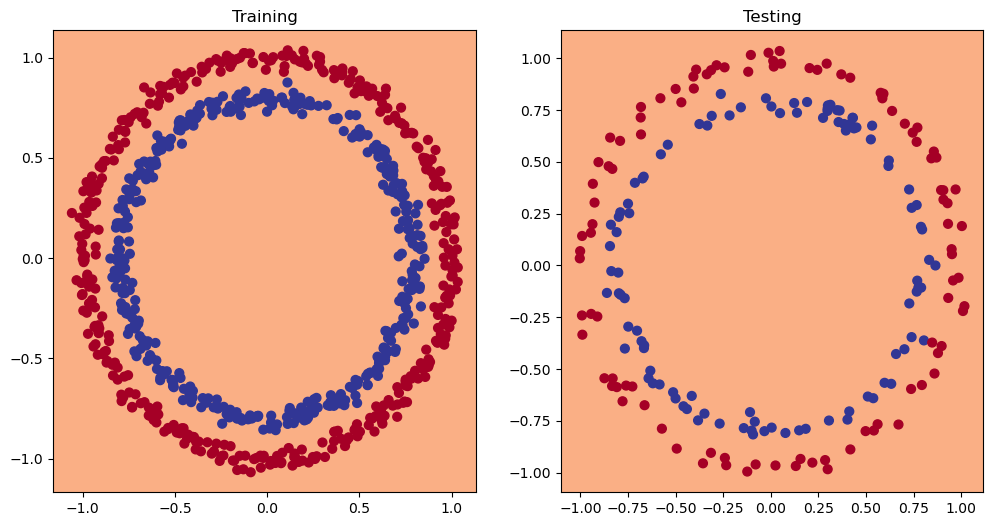

In [31]:
from helper_functions import plot_decision_boundary, plot_predictions

# plot decision boundary of the model 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Training")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer (larger epochs)
* Change the activation functions
* Change the learning rate (smaller learning rate gives better accuracy) 
* Change the loss function

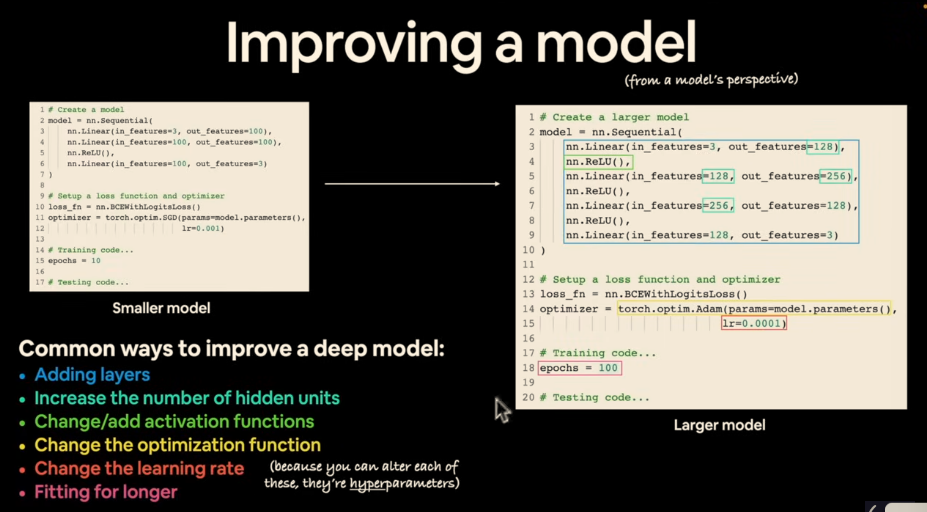

These options are all values that we as (machine learning engineers or data scientists can change) they are referred as **hyperparameters**

In [32]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1()
model_1.to(device), next(model_1.parameters()).device

(CircleModelV1(
   (layer_1): Linear(in_features=2, out_features=10, bias=True)
   (layer_2): Linear(in_features=10, out_features=10, bias=True)
   (layer_3): Linear(in_features=10, out_features=1, bias=True)
 ),
 device(type='cuda', index=0))

In [33]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [34]:
# create a training and evaluation loop
epochs = 10000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.eval()

    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_true=y_train, y_pred=y_preds)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(y_true=y_test, y_pred=test_preds)
    if epoch % 100 == 0:
        print(f"epoch: {epoch} | Loss: {loss:.5f}, accuracy: {acc:.2f} | testing loss: {test_loss:.5f}, test accuracy: {test_acc:.2f} ")
        

epoch: 0 | Loss: 0.69515, accuracy: 50.00 | testing loss: 0.69418, test accuracy: 50.00 
epoch: 100 | Loss: 0.69397, accuracy: 41.62 | testing loss: 0.69321, test accuracy: 44.50 
epoch: 200 | Loss: 0.69360, accuracy: 48.00 | testing loss: 0.69304, test accuracy: 47.50 
epoch: 300 | Loss: 0.69346, accuracy: 49.62 | testing loss: 0.69307, test accuracy: 47.00 
epoch: 400 | Loss: 0.69337, accuracy: 50.50 | testing loss: 0.69314, test accuracy: 46.00 
epoch: 500 | Loss: 0.69332, accuracy: 50.62 | testing loss: 0.69322, test accuracy: 44.50 
epoch: 600 | Loss: 0.69327, accuracy: 50.38 | testing loss: 0.69330, test accuracy: 48.00 
epoch: 700 | Loss: 0.69323, accuracy: 49.75 | testing loss: 0.69338, test accuracy: 51.00 
epoch: 800 | Loss: 0.69319, accuracy: 49.50 | testing loss: 0.69346, test accuracy: 51.50 
epoch: 900 | Loss: 0.69316, accuracy: 49.88 | testing loss: 0.69353, test accuracy: 50.50 
epoch: 1000 | Loss: 0.69314, accuracy: 50.00 | testing loss: 0.69360, test accuracy: 50.00 


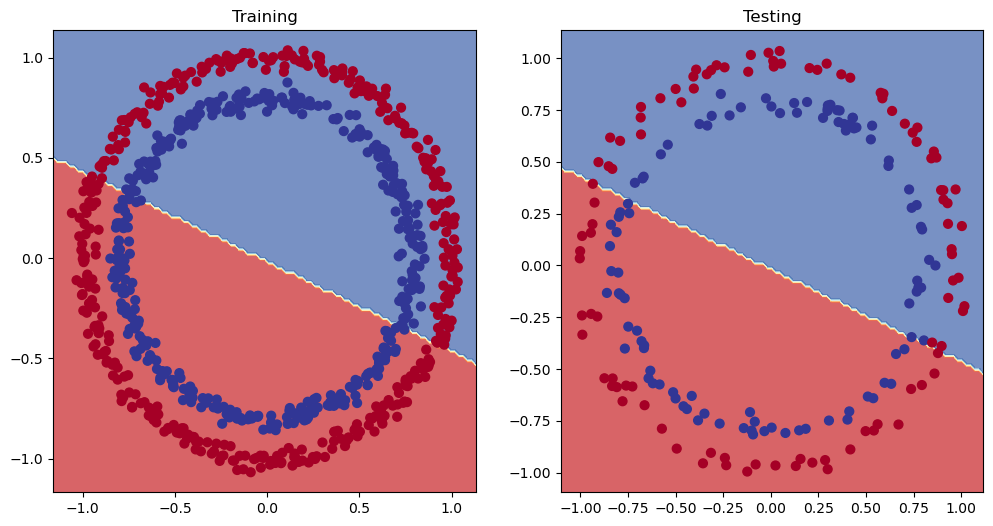

In [35]:
# plot the trained prediction in plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Training")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing")
plot_decision_boundary(model_1, X_test, y_test)

## 5. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of a straight line and non-straight lines?" 

### 5.1 Recreating non-linear data (red blue circles)

In [36]:
# create the dataset
n_samples = 1000 

X, y = make_circles(n_samples=n_samples, noise=0.1, random_state=42)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7121,  0.2847],
         [-0.6787,  0.2073],
         [-0.8660,  0.3437],
         [-0.5176,  0.6206],
         [ 0.4541, -0.8905]]),
 tensor([1., 1., 1., 1., 0.]))

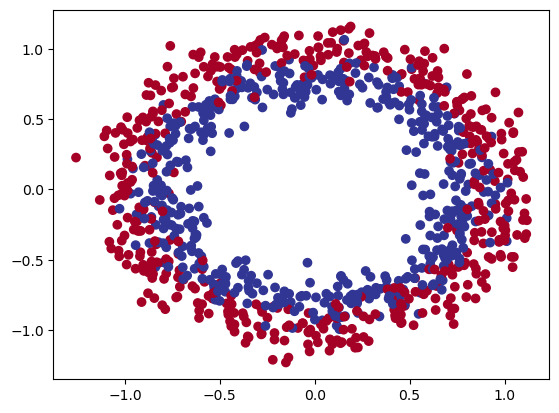

In [37]:
plt.scatter(x=X[:, 0], y=X[:, 1], cmap=plt.cm.RdYlBu, c=y)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### 5.2 Building a model with non-linearity

Artificial neural networks are a large combination of linear and non-linear functions which are potentially able to find patterns in data.

In [39]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        # non-linear activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_2 = CircleModelV2()
model_2.to(device)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [40]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [41]:
epochs = 100000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model_2.train()

    # feed forward
    y_logits = model_2(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # calculate loss and accuracy 
    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_true=y_train, y_pred=y_preds)

    # optim zero grad
    optimizer.zero_grad()

    # backpropagation
    loss.backward()

    # optim step (gradient descent)
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_accuracy = accuracy(y_true=y_test, y_pred=test_preds)
    if epoch % 10000 == 0:
        print(f"epoch: {epoch} | loss: {loss}, accuracy: {acc} | test loss: {test_loss}, accuracy: {test_accuracy}")

epoch: 0 | loss: 0.7058876752853394, accuracy: 50.0 | test loss: 0.6946775913238525, accuracy: 50.0
epoch: 10000 | loss: 0.6838497519493103, accuracy: 57.25 | test loss: 0.6946775913238525, accuracy: 52.5
epoch: 20000 | loss: 0.3583681285381317, accuracy: 86.375 | test loss: 0.6946775913238525, accuracy: 68.5
epoch: 30000 | loss: 0.32757243514060974, accuracy: 86.625 | test loss: 0.6946775913238525, accuracy: 72.0
epoch: 40000 | loss: 0.3269706666469574, accuracy: 86.5 | test loss: 0.6946775913238525, accuracy: 71.5
epoch: 50000 | loss: 0.3268669545650482, accuracy: 86.625 | test loss: 0.6946775913238525, accuracy: 71.5
epoch: 60000 | loss: 0.32679057121276855, accuracy: 86.625 | test loss: 0.6946775913238525, accuracy: 71.5
epoch: 70000 | loss: 0.3266991972923279, accuracy: 86.625 | test loss: 0.6946775913238525, accuracy: 71.5
epoch: 80000 | loss: 0.3265945613384247, accuracy: 86.625 | test loss: 0.6946775913238525, accuracy: 71.5
epoch: 90000 | loss: 0.32648107409477234, accuracy: 8

### 5.3 Evalutating a model trained with non-linear activation functions

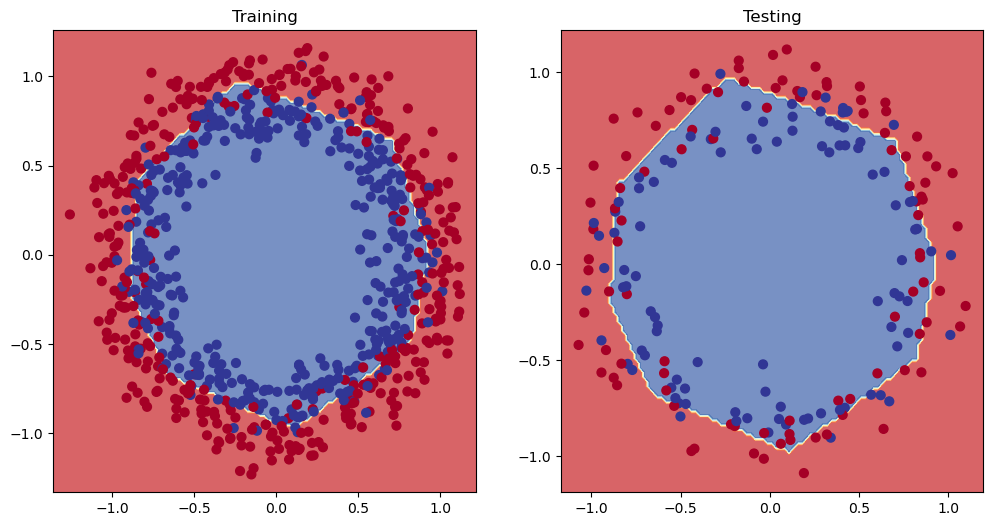

In [42]:
# plot the trained prediction in plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Training")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing")
plot_decision_boundary(model_2, X_test, y_test)

## 6. Replicating non-linear activation function

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data it tries to figure out the patterns on its own. 

And these tools are linear and non-linear functions.

#### 1. ReLU
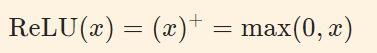

In [43]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

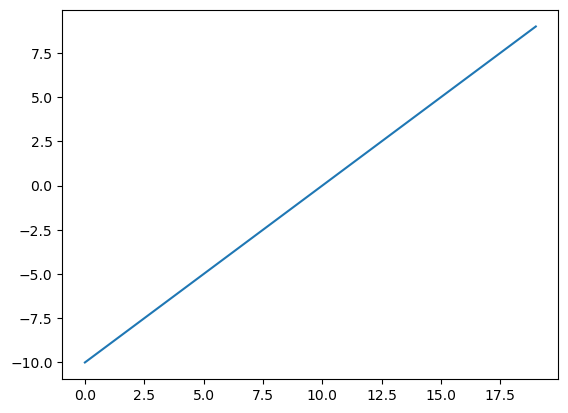

In [44]:
plt.plot(A)

In [45]:
def relu(x: torch.Tensor) -> torch.Tensor: 
    return torch.maximum(torch.tensor(0), x)

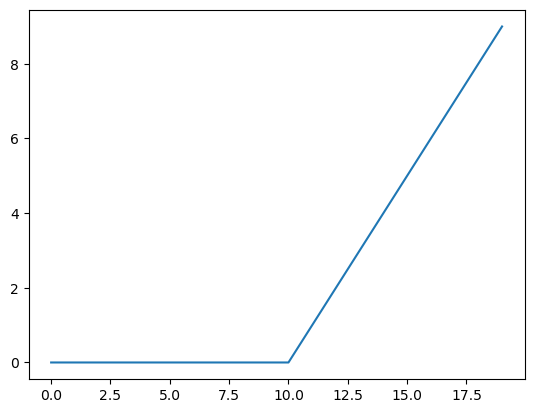

In [46]:
built_in = nn.ReLU()
plt.plot(built_in(A))

#### 2. Sigmoid
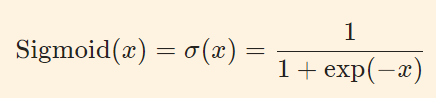

Used to turn raw logits into binary prediction distribution. Usually used in tandem with torch.round to round the numbers between 0 and 1 (binary) with threshold >= 0.5 for 1 and < 0.5 for 0.

In [47]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

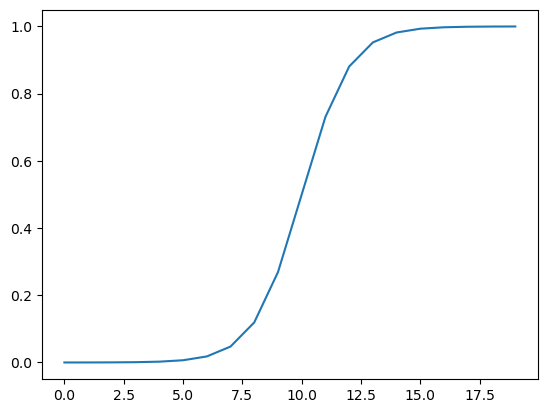

In [48]:
plt.plot(sigmoid(A))

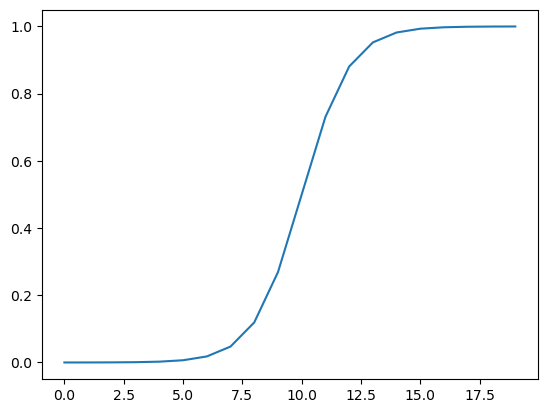

In [49]:
plt.plot(torch.sigmoid(A))

## 7. Putting it all together with a multi-class classification

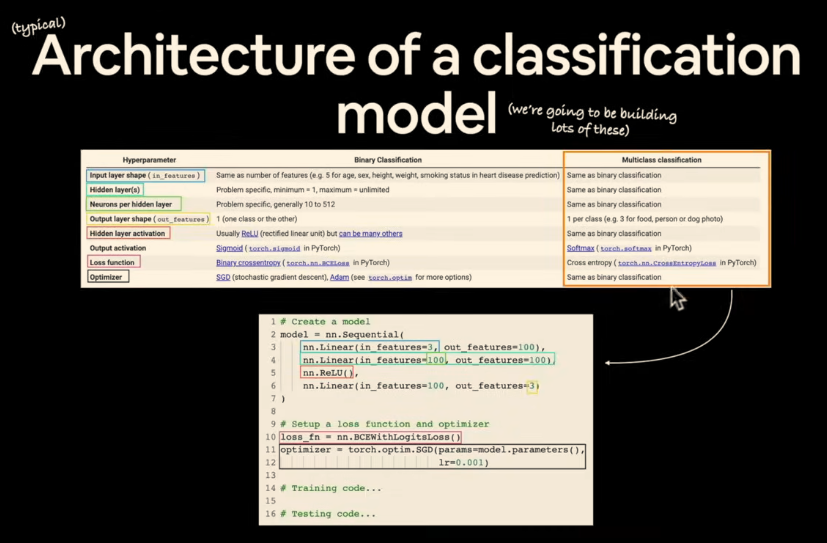

### 7.1 Setup the datasets

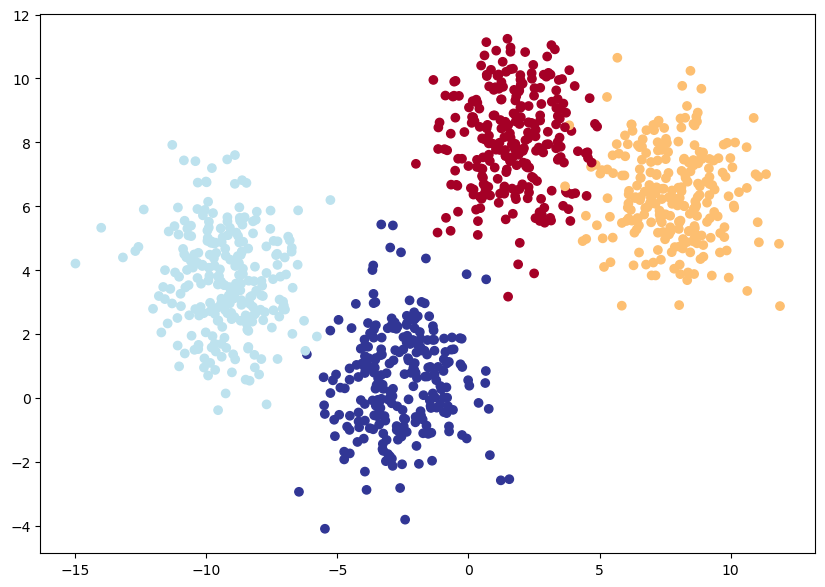

In [91]:
import torch 
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd 

# set hyperparameters
N_SAMPLES = 1000 
CLASS_NUMBERS = 4 ## how many class variations
NUM_FEATURES = 2
RANDOM_SEED = 20

# gather datasets
X_blob, y_blob = make_blobs(n_samples=N_SAMPLES, 
                            n_features=NUM_FEATURES, 
                            random_state=RANDOM_SEED,
                            cluster_std=1.5,
                            centers=CLASS_NUMBERS)

# turn the datasets into tensor
X_blob, y_blob = torch.from_numpy(X_blob).type(torch.float), torch.from_numpy(y_blob).type(torch.LongTensor)

# split data for training and testing
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, 
                                                    random_state=17, 
                                                    test_size=0.2)

# visualize the clusters 
plt.figure(figsize=(10, 7))
plt.scatter(x=X_blob[:, 0], y=X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [92]:
torch.unique(y_blob) # there are four different classes

tensor([0, 1, 2, 3])

In [93]:
pd.DataFrame({"x (x0)": X_blob[:, 0][:10],
              "y (x1)": X_blob[:, 1][:10],
              "color": y_blob[:10]})

,x (x0),y (x1),color
0,1.152329,6.107455,0
1,-8.693801,5.557201,2
2,0.230242,8.662691,0
3,8.182239,4.973128,1
4,-7.767540,2.685589,2
5,7.968377,6.024384,1
6,-10.069714,1.237335,2
7,-7.498119,2.201120,2
8,3.000393,10.687583,0
9,3.473815,8.148907,0


### 7.2 Building a multi-class classification model

In [94]:
class MultiClassificationV0(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=10):
        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), 
            # in this case, the model still can predict the class without 
            # non-linear activation func. Because the classes can be classified with a 
            # straight line
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

torch.cuda.manual_seed(RANDOM_SEED)
model_3 = MultiClassificationV0(NUM_FEATURES, CLASS_NUMBERS)
model_3.to(device)

MultiClassificationV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [95]:
# setup loss function 
loss_fn = nn.CrossEntropyLoss()

# setup optimizer 
# updates the model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.01)

### 7.3 Getting prediction probabilities for a multi-class model and turn it into prediction labels

Logits (raw output of the model) -> prediction probabilites (use `torch.softmax`) -> prediction labels (take the highest prob `torch.argmax()`) 

In [96]:
model_3.eval()
with torch.inference_mode():
    y_logis = model_3(X_blob_test.to(device))

y_logits[:5] # output (logits)

tensor([[-13.2352, -22.2080,  16.5633,  10.0392],
        [ -7.2213, -13.5383,   8.4796,   7.8434],
        [ -3.1713,  -4.5349,   1.6155,   5.3737],
        [ -8.9186, -15.3122,  10.3630,   8.4726],
        [ -6.4529,  -8.5369,   5.7265,   6.1904]], grad_fn=<SliceBackward0>)

In [97]:
# we have to turn the logits into **prediction probabilities**
y_pred_probs = torch.softmax(y_logits, dim=1) # the function applies along the 2nd dimension (dim=1) total in each row should be 1
y_pred_probs[:5]

tensor([[1.1429e-13, 1.4494e-17, 9.9853e-01, 1.4654e-03],
        [9.9242e-08, 1.7917e-10, 6.5390e-01, 3.4610e-01],
        [1.9004e-04, 4.8603e-05, 2.2788e-02, 9.7697e-01],
        [3.6731e-09, 6.1421e-12, 8.6880e-01, 1.3120e-01],
        [1.9824e-06, 2.4668e-07, 3.8604e-01, 6.1395e-01]],
       grad_fn=<SliceBackward0>)

In [98]:
# so we can now get the **prediction labels** from the probability distributions for each point
y_pred = y_pred_probs.argmax(dim=1)
y_pred[:5]

tensor([2, 2, 3, 2, 3])

In [99]:
torch.manual_seed(10)
S = torch.randn(2, 2)
S, S.argmax(dim=1) # returns index of highest values at specific location (row/column) ideally dim=outer_dim
# dim=0 (1st dimension) look for the columns -> group of max index for each column
# dim=1 (2nd dimension) look for the rows -> group of max index for each row

(tensor([[-0.6014, -1.0122],
         [-0.3023, -1.2277]]),
 tensor([0, 0]))

In [57]:
torch.manual_seed(60)
S = torch.randn(3, 3)
S, S.argmax(dim=1) # 1, 2, 0

(tensor([[ 0.7534,  1.8541,  0.7943],
         [-0.7638,  0.7776,  1.1629],
         [ 1.4401,  0.3866,  1.3211]]),
 tensor([1, 2, 0]))

In [101]:
y_logits = model_3(X_blob_train.to(device))
y_pred_prob = torch.softmax(y_logits, dim=1).argmax(dim=1)
y_pred_prob[:5]

tensor([2, 3, 2, 2, 2], device='cuda:0')

### 7.4 Create training and testing loop

In [102]:
# setup training and testing loop
epochs = 10000

# move all devices to the same device 
X_train, X_test = X_blob_train.to(device), X_blob_test.to(device)
y_train, y_test = y_blob_train.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    # set the model into training model
    model_3.train()

    # perform feed forward
    y_logits = model_3(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # calculate loss and accuracy 
    loss = loss_fn(y_logits, y_train)
    pred_acc = accuracy(y_true=y_train, y_pred=y_pred)

    # peform optimizer zero grad 
    optimizer.zero_grad()

    # perform backprop
    loss.backward()

    # gradient descent 
    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(y_true=y_test, y_pred=test_pred)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, accuracy: {pred_acc:.25} | Test loss: {test_loss:.5f}, accuracy: {test_acc:.2f}")

Epoch: 0 | Loss: 1.35451, accuracy: 25.5 | Test loss: 1.32024, accuracy: 25.50
Epoch: 100 | Loss: 0.76846, accuracy: 50.24999999999999289457264 | Test loss: 0.74134, accuracy: 51.00
Epoch: 200 | Loss: 0.64958, accuracy: 60.375 | Test loss: 0.62450, accuracy: 65.00
Epoch: 300 | Loss: 0.54093, accuracy: 83.75 | Test loss: 0.51941, accuracy: 84.00
Epoch: 400 | Loss: 0.40340, accuracy: 91.875 | Test loss: 0.38547, accuracy: 90.00
Epoch: 500 | Loss: 0.29491, accuracy: 94.25 | Test loss: 0.28056, accuracy: 93.50
Epoch: 600 | Loss: 0.23276, accuracy: 96.125 | Test loss: 0.22178, accuracy: 95.50
Epoch: 700 | Loss: 0.19325, accuracy: 97.0 | Test loss: 0.18585, accuracy: 95.50
Epoch: 800 | Loss: 0.16527, accuracy: 97.25 | Test loss: 0.16118, accuracy: 95.50
Epoch: 900 | Loss: 0.14431, accuracy: 97.75 | Test loss: 0.14296, accuracy: 96.00
Epoch: 1000 | Loss: 0.12806, accuracy: 98.125 | Test loss: 0.12897, accuracy: 96.50
Epoch: 1100 | Loss: 0.11517, accuracy: 98.25 | Test loss: 0.11790, accuracy:

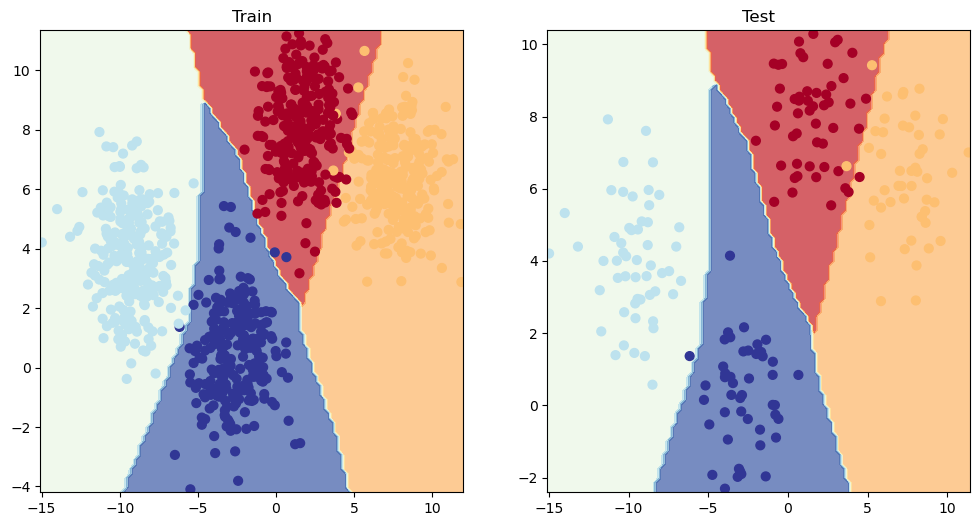

In [104]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_3, X=X_blob, y=y_blob)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model_3, X=X_blob_test, y=y_blob_test)

## 8. A few more classification metrics.. 

extras - https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

Pytorch metrics - https://lightning.ai/docs/torchmetrics/stable/

* Accuracy - out of 100 samples how many the model gets right (good for balance classes)
* Precision
* Recall
* F1-score
* Confusion matrix 
* Classification report

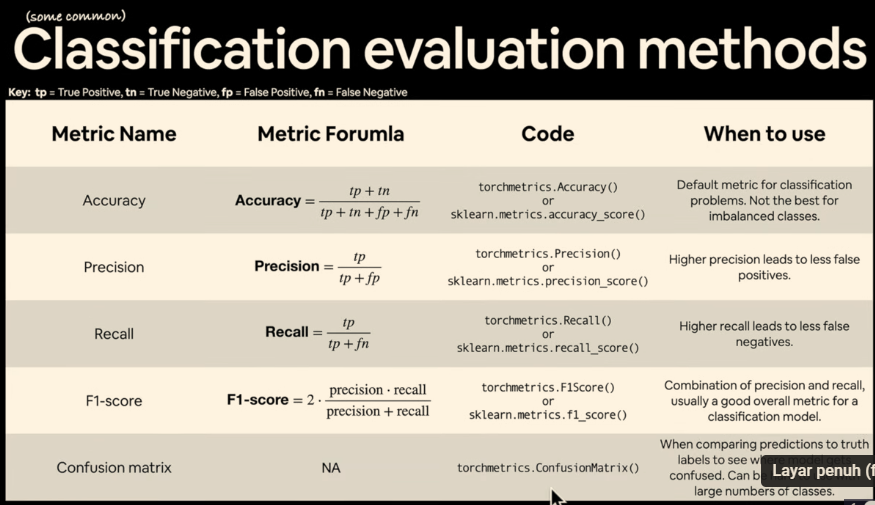

In [109]:
from torchmetrics import Accuracy # type: ignore

# setup metric for accuracy 
# https://lightning.ai/docs/torchmetrics/stable/classification/accuracy.html
torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=CLASS_NUMBERS).to(device)

# calculate accuracy 
torchmetrics_accuracy(y_pred, y_train)

tensor(0.9925, device='cuda:0')